<a href="https://colab.research.google.com/github/bmreiniger/datascience.stackexchange/blob/master/93516_local_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.base import RegressorMixin, BaseEstimator, clone
from sklearn.linear_model import Lasso
from sklearn.utils import check_X_y
import numpy as np

class LocalLinearRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, n_neighbors=10, linear_model=Lasso()):
        self.n_neighbors = n_neighbors
        self.linear_model = linear_model

    def fit(self, X, y=None):
        "Fits the neighbors search."
        X, y = check_X_y(X, y)
        self._fit_X = X
        self._fit_y = y
        self.neighbor_search = NearestNeighbors(n_neighbors=self.n_neighbors)
        self.neighbor_search.fit(X)
        self.local_regressors_ = {}
        return self

    def predict(self, X):
        """Fits linear regressions on the k nearest training points to predict new values.
        
        We don't fit these linear regressions at fit time because there would be so many.
        However, we do save the regressions as we see them to speed up predictions.
        """
        neighbors = self.neighbor_search.kneighbors(X, return_distance=False)
        ksets, mapper = np.unique(neighbors, return_inverse=True, axis=0)
        for kset in ksets:
            if tuple(kset) in self.local_regressors_:
                continue
            local_X = self._fit_X[kset, :]
            local_y = self._fit_y[kset]
            self.local_regressors_[tuple(kset)] = clone(self.linear_model).fit(local_X, local_y)
        return np.array([
            self.local_regressors_[tuple(ksets[mapper[i]])].predict(X[i, :].reshape(1, -1))[0]
            for i in range(X.shape[0])
        ])


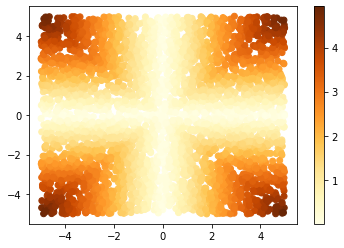

In [2]:
from sklearn.model_selection import train_test_split

X = np.random.random(size=10000).reshape(-1, 2) * 10 - 5
y = np.min(abs(X), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from matplotlib import pyplot as plt
import matplotlib.colors as colors
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='YlOrBr')
plt.colorbar();


In [3]:
%%time
from sklearn.linear_model import LinearRegression

llr = LocalLinearRegressor(n_neighbors=3, linear_model=LinearRegression())
llr.fit(X_train, y_train)
y_pred = llr.predict(X_test)


CPU times: user 650 ms, sys: 36.5 ms, total: 686 ms
Wall time: 643 ms


In [4]:
%%time
# re-predicting should be faster: linear models don't need to be refit
y_pred = llr.predict(X_test)

CPU times: user 67.5 ms, sys: 0 ns, total: 67.5 ms
Wall time: 69 ms


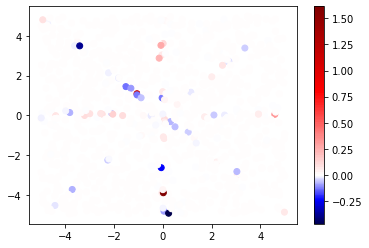

In [5]:
errors = y_pred - y_test

divnorm = colors.TwoSlopeNorm(vmin=errors.min(), vcenter=0, vmax=errors.max())
plt.scatter(X_test[:, 0], X_test[:, 1], c=errors, cmap='seismic', norm=divnorm)
plt.colorbar();

The shape of the true function is such that we should get perfect linear predictions except along the sharp corners along the four lines $x=0,\ y=0,\ y=x,\ y=-x$.